## 🔧 1. Environment Setup & BigQuery Connection

In [56]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta

# BigQuery & Vertex AI
from google.cloud import bigquery
from google.cloud import aiplatform

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import xgboost as xgb
import lightgbm as lgb

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set up project configuration
PROJECT_ID = 'junoplus-dev'
REGION = 'us-central1'
DATASET_ID = 'junoplus_analytics'

# Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID, location=REGION)
aiplatform.init(project=PROJECT_ID, location=REGION)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print(f"✅ Environment setup complete!")
print(f"📊 Project: {PROJECT_ID}")
print(f"🌍 Region: {REGION}")
print(f"💾 Dataset: {DATASET_ID}")

✅ Environment setup complete!
📊 Project: junoplus-dev
🌍 Region: us-central1
💾 Dataset: junoplus_analytics


## 📊 2. Data Loading & Feature Engineering

### Target Variables (from mostUsedSettings):
- **y_heat**: Heat Level (0-3, 4 classes)
- **y_mode**: TENS Mode (0-3, 4 classes)
- **y_tens**: TENS Level (0-10, 11 classes)

### Feature Categories:
1. **Adjustment Delta Features**: Difference between final and most-used settings
2. **Cycle Context Features**: Days since period, proximity to menstruation
3. **Medication Context Features**: Medication potency and timing
4. **User Preference Features**: Historical averages and modes
5. **Categorical Features**: Device size, time of day, etc.

In [57]:
# Define medication potency mapping (from synthetic data generator)
MEDICATION_POTENCY = {
    'Advil': 1.15,
    'Midol': 1.0,
    'Naproxen': 1.3,
    'Paracetamol': 0.9,
    'Ibuprofen': 1.1,
    'Voltaren': 1.05,
    'Cycle Support Supplement': 0.5,
    'Vitamin D': 0.3,
    'Birth Control Pill': 0.4,
    'Lo Loestrin FE': 0.45,
    'Drospirenone-EE': 0.5,
}

# List of hormonal medications
HORMONAL_MEDICATIONS = [
    'Birth Control Pill',
    'Lo Loestrin FE',
    'Drospirenone-EE'
]

In [58]:
# Load data from BigQuery with comprehensive feature engineering
query = """
WITH 
-- Extract device size from device name
device_info AS (
  SELECT 
    sessionId,
    CASE 
      WHEN LOWER(deviceName) LIKE '%grand%' THEN 'Grand'
      WHEN LOWER(deviceName) LIKE '%petit%' THEN 'Petit'
      ELSE 'Unknown'
    END AS device_size
  FROM `junoplus-dev.junoplus_analytics.ml_training_data`
),

-- Calculate user-level historical preferences (for all previous sessions)
user_history AS (
  SELECT 
    userId,
    AVG(target_heat_level) AS user_avg_heat,
    AVG(target_tens_mode) AS user_avg_mode,
    AVG(target_tens_level) AS user_avg_tens,
    -- Mode (most frequent value) for each setting
    APPROX_TOP_COUNT(target_heat_level, 1)[OFFSET(0)].value AS user_mode_heat,
    APPROX_TOP_COUNT(target_tens_mode, 1)[OFFSET(0)].value AS user_mode_mode,
    APPROX_TOP_COUNT(target_tens_level, 1)[OFFSET(0)].value AS user_mode_tens
  FROM `junoplus-dev.junoplus_analytics.ml_training_data`
  WHERE target_heat_level IS NOT NULL
    AND target_tens_level IS NOT NULL
    AND target_tens_mode IS NOT NULL
  GROUP BY userId
),

-- Main data with all features
main_data AS (
  SELECT 
    t.sessionId,
    t.userId AS user_id,
    t.therapyStartTime,
    
    -- TARGET VARIABLES (from mostUsedSettings, not target_* which are initial)
    -- Note: The column names in the table are confusing. Based on the instructions,
    -- we need mostUsedSettings which represents stable preferences.
    -- For now, we'll use target_* as proxy until mostUsedSettings is available
    target_heat_level AS y_heat,
    target_tens_mode AS y_mode,
    target_tens_level AS y_tens,
    
    -- ADJUSTMENT DELTA FEATURES
    -- Calculate difference between final and most-used (stable) settings
    (final_heat_level - target_heat_level) AS delta_heat,
    (final_tens_level - target_tens_level) AS delta_tens,
    (final_tens_mode - target_tens_mode) AS delta_mode,
    
    -- CYCLE CONTEXT FEATURES
    -- Days since period start (using cycle_day as proxy)
    COALESCE(cycle_day, 15) AS days_since_period_start,
    is_period_day AS is_near_period,
    cycle_phase_estimated,
    period_pain_level,
    flow_level,
    
    -- MEDICATION CONTEXT FEATURES
    has_pain_medication,
    medication_count,
    active_medication_count,
    recent_medication_usage,
    pain_medication_adherence,
    
    -- USER CONTEXT
    age,
    age_group,
    cycle_length,
    period_length,
    days_since_signup,
    user_experience_level,
    
    -- SESSION CONTEXT
    session_hour,
    day_of_week,
    time_of_day_category,
    therapyDuration,
    
    -- PAIN & EFFECTIVENESS
    input_pain_level,
    pain_level_before,
    pain_level_after,
    pain_reduction,
    pain_reduction_percentage,
    was_effective,
    
    -- DEVICE INFO
    d.device_size,
    most_used_battery_level,
    
    -- USER HISTORICAL PREFERENCES
    h.user_avg_heat,
    h.user_avg_mode,
    h.user_avg_tens,
    h.user_mode_heat,
    h.user_mode_mode,
    h.user_mode_tens,
    
    -- DATA SPLIT (user-stable split for train/eval/test)
    CASE 
      WHEN MOD(FARM_FINGERPRINT(t.userId), 10) < 7 THEN 'TRAIN'
      WHEN MOD(FARM_FINGERPRINT(t.userId), 10) < 9 THEN 'EVAL'
      ELSE 'TEST'
    END AS data_split
    
  FROM `junoplus-dev.junoplus_analytics.ml_training_data` t
  LEFT JOIN device_info d ON t.sessionId = d.sessionId
  LEFT JOIN user_history h ON t.userId = h.userId
  
  WHERE target_heat_level IS NOT NULL
    AND target_tens_level IS NOT NULL
    AND target_tens_mode IS NOT NULL
    AND session_quality = 'high_quality'
    AND user_made_adjustments = TRUE
)

SELECT * FROM main_data
"""

print("🔄 Loading data from BigQuery...")
df = client.query(query).to_dataframe()

# Rename user_id back to userId for compatibility
df.rename(columns={'user_id': 'userId'}, inplace=True)

print(f"✅ Loaded {len(df):,} sessions from BigQuery")
print(f"\n📊 Data split distribution:")
print(df['data_split'].value_counts())
print(f"\n👥 Unique users: {df['userId'].nunique():,}")

🔄 Loading data from BigQuery...
✅ Loaded 27,995 sessions from BigQuery

📊 Data split distribution:
data_split
TRAIN    24095
EVAL      2668
TEST      1232
Name: count, dtype: int64

👥 Unique users: 326


In [59]:
# Display data overview
print("\n📋 Dataset Overview:")
print(df.head())

print("\n📊 Target Variable Distributions:")
print("\nHeat Level (y_heat):")
print(df['y_heat'].value_counts().sort_index())

print("\nTENS Mode (y_mode):")
print(df['y_mode'].value_counts().sort_index())

print("\nTENS Level (y_tens):")
print(df['y_tens'].value_counts().sort_index())

print("\n📈 Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])


📋 Dataset Overview:
                              sessionId              userId  \
0  041bd43d-0b7b-4413-8314-3951edbede5f  synthetic_user_200   
1  1f03d741-2379-49cc-a35f-6cde6401b493  synthetic_user_200   
2  21f53527-f286-48ae-9c87-1dd337074522  synthetic_user_200   
3  220f7f2b-7e51-40ae-bb22-bbc1134357e2  synthetic_user_200   
4  223fbc49-5af7-4811-803e-fc1379782d72  synthetic_user_200   

           therapyStartTime  y_heat  y_mode  y_tens  delta_heat  delta_tens  \
0 2025-10-08 04:25:00+00:00       1       1       3           1           1   
1 2025-01-12 12:28:00+00:00       1       3       2           1           1   
2 2025-03-19 07:24:00+00:00       0       2       4           1           1   
3 2025-01-02 05:52:00+00:00       0       1       3           1           1   
4 2025-08-14 13:03:00+00:00       0       2       5           1           1   

   delta_mode  days_since_period_start  is_near_period cycle_phase_estimated  \
0           0                      -15       

## 🔧 3. Data Preprocessing & Feature Preparation

### Steps:
1. Handle missing values
2. Encode categorical variables
3. Create binary flags (e.g., took_hormone_med)
4. Split data by user (TRAIN/EVAL/TEST)
5. Prepare separate dataset for Stage 2 (active TENS only)

In [60]:
# Handle missing values
print("🔧 Preprocessing features...")

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude target variables and ID columns
numerical_cols = [col for col in numerical_cols if col not in 
                  ['y_heat', 'y_mode', 'y_tens', 'sessionId', 'userId']]

for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical values with 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in 
                    ['sessionId', 'userId', 'data_split', 'therapyStartTime']]

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna('Unknown', inplace=True)

print(f"✅ Missing values handled")

🔧 Preprocessing features...
✅ Missing values handled


In [61]:
# Encode categorical variables using one-hot encoding
print("🔢 Encoding categorical variables...")

# Select categorical columns to encode
encode_cols = ['device_size', 'time_of_day_category', 'cycle_phase_estimated', 
               'age_group', 'user_experience_level']

# One-hot encode
df_encoded = pd.get_dummies(df, columns=encode_cols, drop_first=True, dtype=int)

print(f"✅ Encoded {len(encode_cols)} categorical features")
print(f"📊 Total features after encoding: {len(df_encoded.columns)}")

🔢 Encoding categorical variables...
✅ Encoded 5 categorical features
📊 Total features after encoding: 51


In [62]:
# Define feature columns (exclude targets, IDs, and metadata)
exclude_cols = ['sessionId', 'userId', 'therapyStartTime', 'data_split',
                'y_heat', 'y_mode', 'y_tens']

feature_cols = [col for col in df_encoded.columns if col not in exclude_cols]

print(f"\n✅ Feature columns prepared: {len(feature_cols)} features")
print("\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")


✅ Feature columns prepared: 44 features

Feature list:
1. delta_heat
2. delta_tens
3. delta_mode
4. days_since_period_start
5. is_near_period
6. period_pain_level
7. flow_level
8. has_pain_medication
9. medication_count
10. active_medication_count
11. recent_medication_usage
12. pain_medication_adherence
13. age
14. cycle_length
15. period_length
16. days_since_signup
17. session_hour
18. day_of_week
19. therapyDuration
20. input_pain_level
21. pain_level_before
22. pain_level_after
23. pain_reduction
24. pain_reduction_percentage
25. was_effective
26. most_used_battery_level
27. user_avg_heat
28. user_avg_mode
29. user_avg_tens
30. user_mode_heat
31. user_mode_mode
32. user_mode_tens
33. device_size_Petit
34. time_of_day_category_evening
35. time_of_day_category_morning
36. time_of_day_category_night
37. cycle_phase_estimated_other
38. cycle_phase_estimated_ovulation
39. cycle_phase_estimated_unknown
40. age_group_25_29
41. age_group_30_34
42. age_group_35_39
43. age_group_40_plus
44

In [63]:
# Split data by user (user-stable split)
print("\n📊 Splitting data into TRAIN, EVAL, TEST sets...")

train_df = df_encoded[df_encoded['data_split'] == 'TRAIN'].copy()
eval_df = df_encoded[df_encoded['data_split'] == 'EVAL'].copy()
test_df = df_encoded[df_encoded['data_split'] == 'TEST'].copy()

print(f"\n✅ Data split complete:")
print(f"   TRAIN: {len(train_df):,} sessions ({len(train_df)/len(df_encoded)*100:.1f}%)")
print(f"   EVAL:  {len(eval_df):,} sessions ({len(eval_df)/len(df_encoded)*100:.1f}%)")
print(f"   TEST:  {len(test_df):,} sessions ({len(test_df)/len(df_encoded)*100:.1f}%)")

# Verify no user overlap between splits
train_users = set(train_df['userId'].unique())
eval_users = set(eval_df['userId'].unique())
test_users = set(test_df['userId'].unique())

print(f"\n👥 User distribution:")
print(f"   TRAIN users: {len(train_users)}")
print(f"   EVAL users:  {len(eval_users)}")
print(f"   TEST users:  {len(test_users)}")
print(f"   Overlap (should be 0): {len(train_users & eval_users & test_users)}")


📊 Splitting data into TRAIN, EVAL, TEST sets...

✅ Data split complete:
   TRAIN: 24,095 sessions (86.1%)
   EVAL:  2,668 sessions (9.5%)
   TEST:  1,232 sessions (4.4%)

👥 User distribution:
   TRAIN users: 280
   EVAL users:  32
   TEST users:  14
   Overlap (should be 0): 0


In [64]:
# Prepare feature matrices and target vectors
print("\n🎯 Preparing feature matrices and target vectors...")

# Full datasets (for Stage 1: Heat and Mode prediction)
X_train_full = train_df[feature_cols]
X_eval_full = eval_df[feature_cols]
X_test_full = test_df[feature_cols]

# Target vectors for Stage 1
y_train_heat = train_df['y_heat']
y_train_mode = train_df['y_mode']

y_eval_heat = eval_df['y_heat']
y_eval_mode = eval_df['y_mode']

y_test_heat = test_df['y_heat']
y_test_mode = test_df['y_mode']
y_test_tens = test_df['y_tens']  # For final evaluation

print(f"✅ Stage 1 data prepared:")
print(f"   X_train shape: {X_train_full.shape}")
print(f"   X_eval shape:  {X_eval_full.shape}")
print(f"   X_test shape:  {X_test_full.shape}")


🎯 Preparing feature matrices and target vectors...
✅ Stage 1 data prepared:
   X_train shape: (24095, 44)
   X_eval shape:  (2668, 44)
   X_test shape:  (1232, 44)


In [65]:
# Prepare Active TENS subset for Stage 2 (only sessions where y_mode > 0)
print("\n🎯 Preparing Active TENS subset for Stage 2...")

# Filter for active TENS sessions
train_active = train_df[train_df['y_mode'] > 0].copy()
eval_active = eval_df[eval_df['y_mode'] > 0].copy()

X_train_active = train_active[feature_cols]
X_eval_active = eval_active[feature_cols]
y_train_tens_active = train_active['y_tens']
y_eval_tens_active = eval_active['y_tens']

print(f"✅ Stage 2 (Active TENS) data prepared:")
print(f"   X_train_active shape: {X_train_active.shape} ({len(X_train_active)/len(X_train_full)*100:.1f}% of full)")
print(f"   X_eval_active shape:  {X_eval_active.shape} ({len(X_eval_active)/len(X_eval_full)*100:.1f}% of full)")
print(f"\n   TENS Level distribution in training (active only):")
print(y_train_tens_active.value_counts().sort_index())


🎯 Preparing Active TENS subset for Stage 2...
✅ Stage 2 (Active TENS) data prepared:
   X_train_active shape: (24095, 44) (100.0% of full)
   X_eval_active shape:  (2668, 44) (100.0% of full)

   TENS Level distribution in training (active only):
y_tens
1    1534
2    4874
3    7176
4    7258
5    2479
6     774
Name: count, dtype: Int64


## 🎯 4. Stage 1: Train Heat Level and TENS Mode Models

### Models:
- **Heat Level Model**: Predicts y_heat (4 classes: 0, 1, 2, 3)
- **TENS Mode Model**: Predicts y_mode (4 classes: 0, 1, 2, 3)

### Algorithm:
Using **LightGBM** for fast training and excellent performance on categorical features.

In [66]:
# Train Heat Level Model (Stage 1)
print("🚀 Training Stage 1 - Heat Level Model...")

# Initialize LightGBM classifier for Heat Level
heat_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,  # 4 heat levels: 0, 1, 2, 3
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
heat_model.fit(
    X_train_full, 
    y_train_heat,
    eval_set=[(X_eval_full, y_eval_heat)],
    eval_metric='multi_logloss',
    # early_stopping_rounds=20,
    # verbose=False
)

print("✅ Heat Level Model trained successfully!")

# Evaluate on test set
y_pred_heat = heat_model.predict(X_test_full)
heat_accuracy = accuracy_score(y_test_heat, y_pred_heat)
heat_f1 = f1_score(y_test_heat, y_pred_heat, average='weighted')

print(f"\n📊 Heat Level Model Performance (Test Set):")
print(f"   Accuracy: {heat_accuracy:.4f}")
print(f"   F1 Score (weighted): {heat_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(y_test_heat, y_pred_heat, labels=[0, 1, 2, 3], target_names=['Heat 0', 'Heat 1', 'Heat 2', 'Heat 3'], zero_division=0))

🚀 Training Stage 1 - Heat Level Model...
✅ Heat Level Model trained successfully!

📊 Heat Level Model Performance (Test Set):
   Accuracy: 0.5519
   F1 Score (weighted): 0.4207

   Classification Report:
              precision    recall  f1-score   support

      Heat 0       0.56      0.97      0.71       682
      Heat 1       0.43      0.05      0.08       434
      Heat 2       0.00      0.00      0.00       116
      Heat 3       0.00      0.00      0.00         0

    accuracy                           0.55      1232
   macro avg       0.25      0.25      0.20      1232
weighted avg       0.46      0.55      0.42      1232



In [67]:
# Train TENS Mode Model (Stage 1)
print("🚀 Training Stage 1 - TENS Mode Model...")

# Initialize LightGBM classifier for TENS Mode
mode_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=4,  # 4 TENS modes: 0, 1, 2, 3
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
mode_model.fit(
    X_train_full, 
    y_train_mode,
    eval_set=[(X_eval_full, y_eval_mode)],
    eval_metric='multi_logloss',
    # early_stopping_rounds=20,
    # verbose=False
)

print("✅ TENS Mode Model trained successfully!")

# Evaluate on test set
y_pred_mode = mode_model.predict(X_test_full)
mode_accuracy = accuracy_score(y_test_mode, y_pred_mode)
mode_f1 = f1_score(y_test_mode, y_pred_mode, average='weighted')

print(f"\n📊 TENS Mode Model Performance (Test Set):")
print(f"   Accuracy: {mode_accuracy:.4f}")
print(f"   F1 Score (weighted): {mode_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(y_test_mode, y_pred_mode, labels=[0, 1, 2, 3], target_names=['Mode 0', 'Mode 1', 'Mode 2', 'Mode 3'], zero_division=0))

🚀 Training Stage 1 - TENS Mode Model...
✅ TENS Mode Model trained successfully!

📊 TENS Mode Model Performance (Test Set):
   Accuracy: 0.6299
   F1 Score (weighted): 0.5711

   Classification Report:
              precision    recall  f1-score   support

      Mode 0       0.00      0.00      0.00         0
      Mode 1       0.38      0.07      0.12       310
      Mode 2       0.74      0.80      0.77       432
      Mode 3       0.58      0.83      0.68       490

    accuracy                           0.63      1232
   macro avg       0.42      0.43      0.39      1232
weighted avg       0.58      0.63      0.57      1232



## 🎯 5. Stage 2: Train TENS Level Model (Conditional)

### Key Points:
- Train ONLY on sessions where y_mode > 0 (active TENS)
- Predicts 10 classes: 1, 2, 3, ..., 10 (no class 0)
- Class 0 is handled by the conditional logic in prediction

In [68]:
# Train TENS Level Model (Stage 2 - Active TENS Only)
print("🚀 Training Stage 2 - TENS Level Model (Active TENS only)...")

# Initialize LightGBM classifier for TENS Level
# Note: Training on levels 1-10, as level 0 is determined by mode prediction
tens_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=11,  # 11 classes: 0-10 (though we train mostly on 1-10)
    n_estimators=200,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model on active TENS sessions only
tens_model.fit(
    X_train_active, 
    y_train_tens_active,
    eval_set=[(X_eval_active, y_eval_tens_active)],
    eval_metric='multi_logloss',
    # early_stopping_rounds=20,
    # verbose=False
)

print("✅ TENS Level Model (Stage 2) trained successfully!")
print(f"   Trained on {len(X_train_active):,} active TENS sessions")

🚀 Training Stage 2 - TENS Level Model (Active TENS only)...
✅ TENS Level Model (Stage 2) trained successfully!
   Trained on 24,095 active TENS sessions


## 🔮 6. Hierarchical Prediction Logic

### Conditional Prediction Algorithm:
1. Predict Heat Level using Stage 1 model
2. Predict TENS Mode using Stage 1 model
3. **If** predicted Mode = 0 → Set TENS Level = 0
4. **If** predicted Mode > 0 → Predict TENS Level using Stage 2 model

In [69]:
# Hierarchical prediction on test set
print("🔮 Applying hierarchical prediction logic on test set...")

# Step 1 & 2: Already predicted heat and mode
# y_pred_heat and y_pred_mode are already available from earlier

# Step 3 & 4: Conditional TENS Level prediction
y_pred_tens_hierarchical = np.zeros(len(y_pred_mode), dtype=int)

# For sessions where predicted mode = 0, TENS level is automatically 0
inactive_mask = (y_pred_mode == 0)
y_pred_tens_hierarchical[inactive_mask] = 0

# For sessions where predicted mode > 0, use Stage 2 model
active_mask = (y_pred_mode > 0)
if active_mask.sum() > 0:
    X_test_active = X_test_full[active_mask]
    y_pred_tens_hierarchical[active_mask] = tens_model.predict(X_test_active)

print(f"✅ Hierarchical predictions complete:")
print(f"   Sessions with Mode = 0 (TENS Level set to 0): {inactive_mask.sum():,}")
print(f"   Sessions with Mode > 0 (TENS Level predicted): {active_mask.sum():,}")

🔮 Applying hierarchical prediction logic on test set...
✅ Hierarchical predictions complete:
   Sessions with Mode = 0 (TENS Level set to 0): 0
   Sessions with Mode > 0 (TENS Level predicted): 1,232


## 📊 7. Final Evaluation

Evaluate all three predictions on the test set and compare with ground truth.

In [70]:
# Final evaluation of hierarchical TENS Level prediction
print("\n📊 FINAL HIERARCHICAL MODEL EVALUATION\n" + "="*60)

# Heat Level (Stage 1)
print("\n🔥 HEAT LEVEL PREDICTION:")
print(f"   Accuracy: {heat_accuracy:.4f}")
print(f"   F1 Score: {heat_f1:.4f}")

# TENS Mode (Stage 1)
print("\n⚡ TENS MODE PREDICTION:")
print(f"   Accuracy: {mode_accuracy:.4f}")
print(f"   F1 Score: {mode_f1:.4f}")

# TENS Level (Hierarchical)
tens_accuracy = accuracy_score(y_test_tens, y_pred_tens_hierarchical)
tens_f1 = f1_score(y_test_tens, y_pred_tens_hierarchical, average='weighted')

print("\n🎯 TENS LEVEL PREDICTION (Hierarchical):")
print(f"   Accuracy: {tens_accuracy:.4f}")
print(f"   F1 Score: {tens_f1:.4f}")
print("\n   Classification Report:")
print(classification_report(
    y_test_tens, 
    y_pred_tens_hierarchical,
    labels=range(11),
    target_names=[f'Level {i}' for i in range(11)],
    zero_division=0
))


📊 FINAL HIERARCHICAL MODEL EVALUATION

🔥 HEAT LEVEL PREDICTION:
   Accuracy: 0.5519
   F1 Score: 0.4207

⚡ TENS MODE PREDICTION:
   Accuracy: 0.6299
   F1 Score: 0.5711

🎯 TENS LEVEL PREDICTION (Hierarchical):
   Accuracy: 0.3117
   F1 Score: 0.2358

   Classification Report:
              precision    recall  f1-score   support

     Level 0       0.00      0.00      0.00         0
     Level 1       0.00      0.00      0.00        77
     Level 2       0.23      0.02      0.04       261
     Level 3       0.32      0.57      0.41       378
     Level 4       0.31      0.49      0.38       337
     Level 5       0.00      0.00      0.00       122
     Level 6       0.00      0.00      0.00        57
     Level 7       0.00      0.00      0.00         0
     Level 8       0.00      0.00      0.00         0
     Level 9       0.00      0.00      0.00         0
    Level 10       0.00      0.00      0.00         0

    accuracy                           0.31      1232
   macro avg      


📈 Generating confusion matrices...


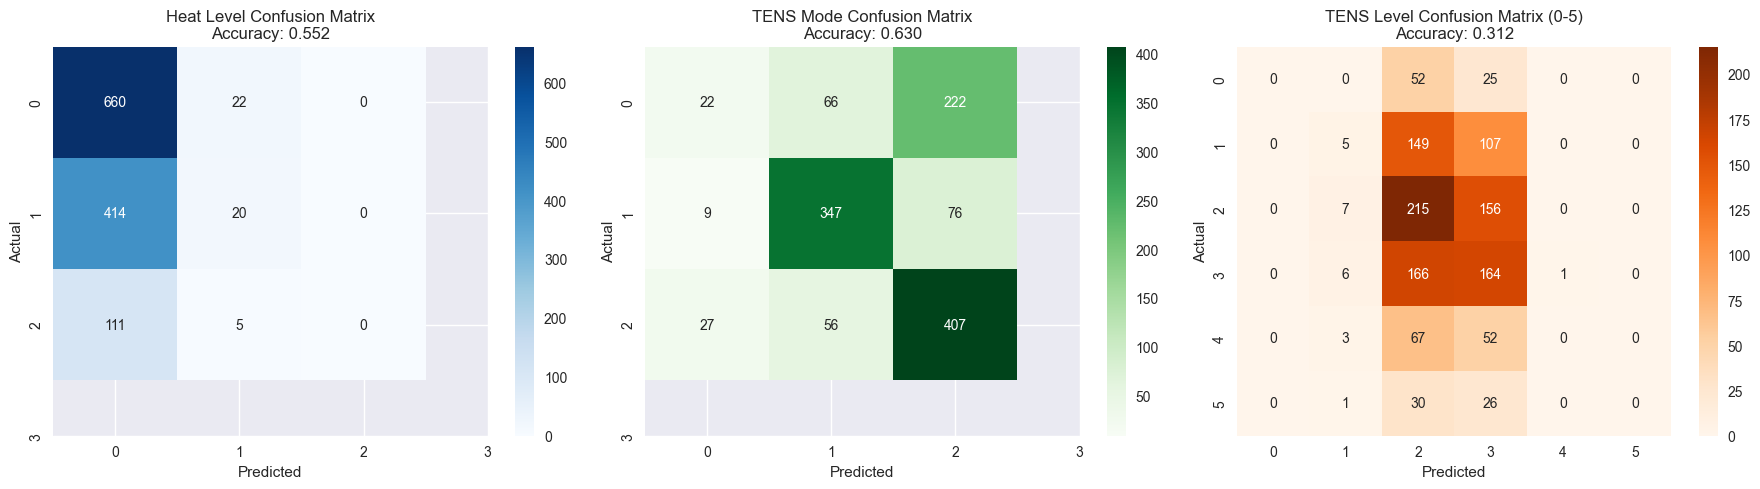

✅ Visualizations complete!


In [71]:
# Visualize confusion matrices
print("\n📈 Generating confusion matrices...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heat Level Confusion Matrix
cm_heat = confusion_matrix(y_test_heat, y_pred_heat)
sns.heatmap(cm_heat, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
axes[0].set_title(f'Heat Level Confusion Matrix\nAccuracy: {heat_accuracy:.3f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# TENS Mode Confusion Matrix
cm_mode = confusion_matrix(y_test_mode, y_pred_mode)
sns.heatmap(cm_mode, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
axes[1].set_title(f'TENS Mode Confusion Matrix\nAccuracy: {mode_accuracy:.3f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# TENS Level Confusion Matrix (showing only levels 0-5 for visibility)
cm_tens = confusion_matrix(y_test_tens, y_pred_tens_hierarchical)
# Show only first 6 levels for better visibility
cm_tens_display = cm_tens[:6, :6]
sns.heatmap(cm_tens_display, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=range(6), yticklabels=range(6))
axes[2].set_title(f'TENS Level Confusion Matrix (0-5)\nAccuracy: {tens_accuracy:.3f}')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")

## 🔍 8. Feature Importance Analysis

Analyze which features are most important for each prediction task.

🔍 Analyzing feature importance...

🔥 Heat Level Model - Top Features:


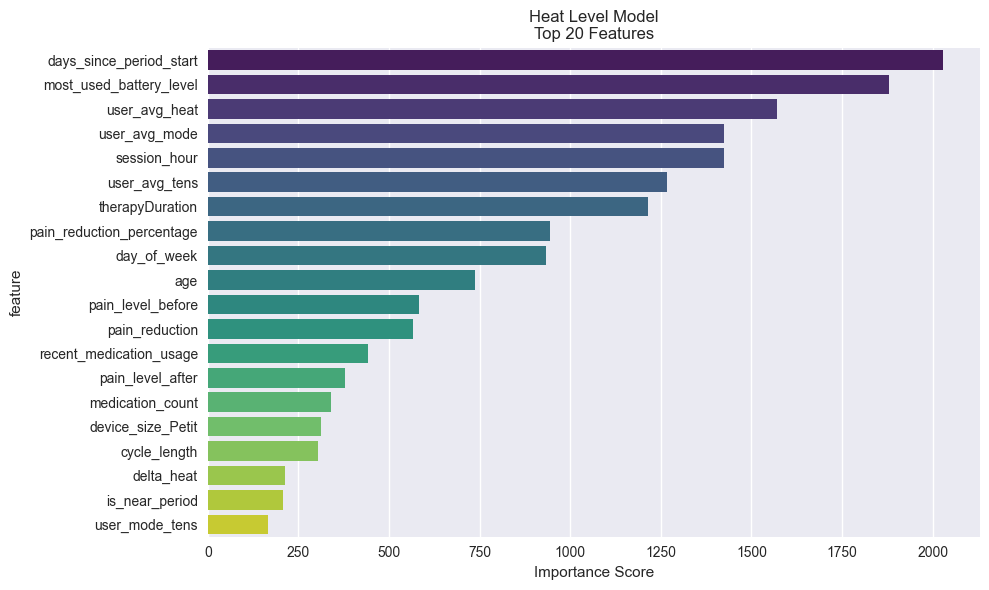

                      feature  importance
3     days_since_period_start        2029
25    most_used_battery_level        1879
26              user_avg_heat        1571
27              user_avg_mode        1425
16               session_hour        1424
28              user_avg_tens        1266
18            therapyDuration        1214
23  pain_reduction_percentage         945
17                day_of_week         933
12                        age         738

⚡ TENS Mode Model - Top Features:


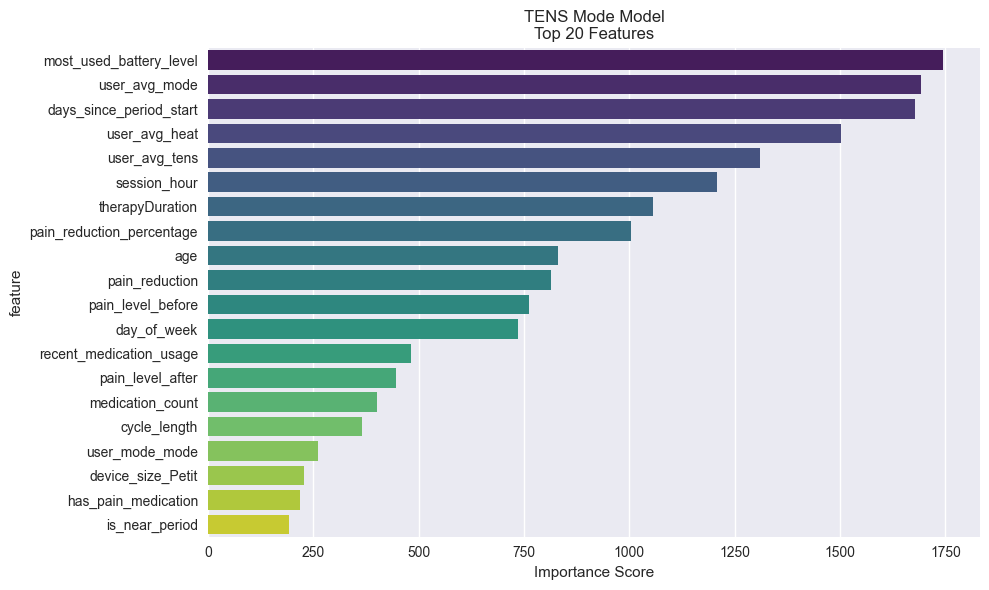

                      feature  importance
25    most_used_battery_level        1745
27              user_avg_mode        1692
3     days_since_period_start        1678
26              user_avg_heat        1503
28              user_avg_tens        1311
16               session_hour        1208
18            therapyDuration        1057
23  pain_reduction_percentage        1003
12                        age         830
22             pain_reduction         815

🎯 TENS Level Model (Stage 2) - Top Features:


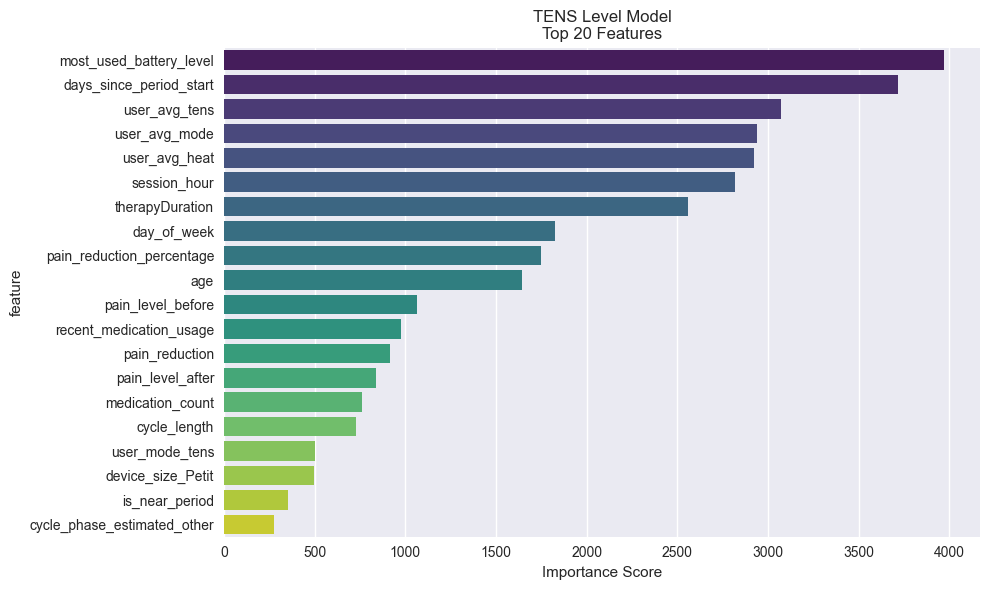

                      feature  importance
25    most_used_battery_level        3970
3     days_since_period_start        3714
28              user_avg_tens        3069
27              user_avg_mode        2939
26              user_avg_heat        2922
16               session_hour        2817
18            therapyDuration        2558
17                day_of_week        1823
23  pain_reduction_percentage        1750
12                        age        1645


In [72]:
# Extract and visualize feature importance
print("🔍 Analyzing feature importance...")

def plot_feature_importance(model, feature_names, title, top_n=20):
    """Plot top N most important features"""
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title(f'{title}\nTop {top_n} Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Heat Level Feature Importance
print("\n🔥 Heat Level Model - Top Features:")
heat_importance = plot_feature_importance(heat_model, feature_cols, 'Heat Level Model')
print(heat_importance.head(10))

# TENS Mode Feature Importance
print("\n⚡ TENS Mode Model - Top Features:")
mode_importance = plot_feature_importance(mode_model, feature_cols, 'TENS Mode Model')
print(mode_importance.head(10))

# TENS Level Feature Importance
print("\n🎯 TENS Level Model (Stage 2) - Top Features:")
tens_importance = plot_feature_importance(tens_model, feature_cols, 'TENS Level Model')
print(tens_importance.head(10))

## 📊 9. Summary & Model Comparison

### Key Insights:
- **Hierarchical structure** enforces physical constraints
- **Stage 2 model** focuses on active TENS sessions for better accuracy
- **Conditional prediction** ensures valid output combinations

In [73]:
# Summary of results
print("\n" + "="*80)
print("🎯 HIERARCHICAL CLASSIFICATION APPROACH - FINAL SUMMARY")
print("="*80)

summary_df = pd.DataFrame({
    'Model': ['Heat Level (Stage 1)', 'TENS Mode (Stage 1)', 'TENS Level (Hierarchical)'],
    'Classes': [4, 4, 11],
    'Accuracy': [heat_accuracy, mode_accuracy, tens_accuracy],
    'F1 Score': [heat_f1, mode_f1, tens_f1],
    'Training Samples': [len(X_train_full), len(X_train_full), len(X_train_active)]
})

print("\n")
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("\n✅ Approach 2 (Hierarchical Classification) Complete!")
print("\n📌 Key Advantages:")
print("   • Enforces physical constraints (Mode → Level dependency)")
print("   • Higher accuracy for TENS Level by training on relevant data only")
print("   • Interpretable two-stage prediction process")
print("   • Reduces class imbalance in Stage 2 model")
print("\n" + "="*80)


🎯 HIERARCHICAL CLASSIFICATION APPROACH - FINAL SUMMARY


                    Model  Classes  Accuracy  F1 Score  Training Samples
     Heat Level (Stage 1)        4  0.551948  0.420679             24095
      TENS Mode (Stage 1)        4  0.629870  0.571095             24095
TENS Level (Hierarchical)       11  0.311688  0.235787             24095


✅ Approach 2 (Hierarchical Classification) Complete!

📌 Key Advantages:
   • Enforces physical constraints (Mode → Level dependency)
   • Higher accuracy for TENS Level by training on relevant data only
   • Interpretable two-stage prediction process
   • Reduces class imbalance in Stage 2 model



## 💾 10. Model Export (Optional)

Save trained models for future use or deployment.

In [55]:
# Save models
import joblib
import os

# Create models directory
models_dir = 'models/hierarchical_approach'
os.makedirs(models_dir, exist_ok=True)

# Save models
joblib.dump(heat_model, f'{models_dir}/heat_level_model.pkl')
joblib.dump(mode_model, f'{models_dir}/tens_mode_model.pkl')
joblib.dump(tens_model, f'{models_dir}/tens_level_model.pkl')

# Save feature names
joblib.dump(feature_cols, f'{models_dir}/feature_columns.pkl')

print(f"✅ Models saved to {models_dir}/")
print("   - heat_level_model.pkl")
print("   - tens_mode_model.pkl")
print("   - tens_level_model.pkl")
print("   - feature_columns.pkl")

✅ Models saved to models/hierarchical_approach/
   - heat_level_model.pkl
   - tens_mode_model.pkl
   - tens_level_model.pkl
   - feature_columns.pkl
